# **Ejercicio 12: Multimodal Embeddings**

## **Nombre:** Nelson Casa

## Objetivo de la práctica

El objetivo de este ejercicio es observar cómo modelos multimodales como CLIP llevan texto e imágenes al mismo espacio vectorial, y verificar graficando embeddings en 2D.

### Pasos:

1. Obtener embeddings de imágenes y textos con CLIP.
2. Mostrar que ambos viven en el mismo espacio (misma dimensión y comparables).
3. Proyectar los vectores a 2D (PCA / t-SNE / UMAP) y graficarlos en un plano.
4. Verificar emparejamientos usando cosine similarity (búsqueda texto→imagen e imagen→texto).

Se instalan las librerías necesarias para ejecutar el taller.  
Se incluye **PyTorch** para el manejo de tensores y ejecución del modelo, **CLIP** para trabajar con embeddings multimodales, y librerías adicionales para procesamiento de texto, visualización y análisis de datos.

Estas dependencias permiten cargar el modelo, procesar imágenes y texto, y analizar los resultados obtenidos.

In [ ]:
!pip install torch torchvision ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install scikit-learn matplotlib pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-mo43_zvj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-mo43_zvj
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=fbf5282d7fe9cf2936cb94d88e39c63bb00d178fa13d3567f02b8b70e81a2f7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-t_vj45da/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


Se importan las librerías necesarias para el desarrollo del taller.  
Se utilizan **PyTorch** y **CLIP** para el manejo del modelo y los embeddings, **NumPy** para operaciones numéricas y **PIL** para el procesamiento de imágenes.

Además, se incluyen **PCA** y **t-SNE** para la reducción de dimensionalidad, **cosine similarity** para medir la similitud entre embeddings, y **Matplotlib** para la visualización de resultados.

In [ ]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics.pairwise import cosine_similarity
import urllib.request


En esta celda se selecciona el dispositivo de ejecución (CPU o GPU) y se carga el modelo CLIP junto con su función de preprocesamiento.  
Esto permite optimizar el rendimiento y preparar el modelo para generar embeddings de imágenes y texto.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)
print("Dispositivo:", device)


Se define un conjunto de imágenes de distintas categorías y se descargan desde internet.  
Estas imágenes serán utilizadas como datos de entrada para generar embeddings visuales y evaluar la capacidad del modelo CLIP para diferenciar conceptos.

In [ ]:
image_urls = {
    # Perros
    "perro1.jpg": "https://images.unsplash.com/photo-1517849845537-4d257902454a",
    "perro2.jpg": "https://images.unsplash.com/photo-1558788353-f76d92427f16",

    # Gatos
    "gato1.jpg": "https://images.unsplash.com/photo-1518791841217-8f162f1e1131",
    "gato2.jpg": "https://images.unsplash.com/photo-1595433707802-6b2626ef1c91",

    # Autos
    "auto1.jpg": "https://images.unsplash.com/photo-1503376780353-7e6692767b70",
    "auto2.jpg": "https://images.unsplash.com/photo-1549924231-f129b911e442",

    # Aviones
    "avion1.jpg": "https://images.unsplash.com/photo-1529070538774-1843cb3265df",
    "avion2.jpg": "https://images.unsplash.com/photo-1436491865332-7a61a109cc05",

    # Personas
    "persona1.jpg": "https://images.unsplash.com/photo-1500648767791-00dcc994a43e",
    "persona2.jpg": "https://images.unsplash.com/photo-1529626455594-4ff0802cfb7e",

    # Comida
    "comida1.jpg": "https://images.unsplash.com/photo-1546069901-ba9599a7e63c",
    "comida2.jpg": "https://images.unsplash.com/photo-1504674900247-0877df9cc836",
}

image_paths = []

for name, url in image_urls.items():
    urllib.request.urlretrieve(url + "?w=640", name)
    image_paths.append(name)

len(image_paths)


12

Cargamos las imágenes en un conjunto de datos (lista). Después utilizamos torch para obtener los embeddings de las imágenes.

In [ ]:
images = [
    preprocess(Image.open(p).convert("RGB")).unsqueeze(0).to(device)
    for p in image_paths
]

with torch.no_grad():
    image_embeddings = torch.cat([model.encode_image(img) for img in images])

image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

print("Embeddings de imágenes:", image_embeddings.shape)


Embeddings de imágenes: torch.Size([12, 512])


Creamos una lista de textos y obtenemos sus embeddings.

In [ ]:
texts = [
    "dog",
    "cat",
    "car",
    "airplane",
    "a person with lazy hair and brown",
    "a person white",
    "food"
]

text_tokens = clip.tokenize(texts).to(device)

with torch.no_grad():
    text_embeddings = model.encode_text(text_tokens)

text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

print("Embeddings de texto:", text_embeddings.shape)


Embeddings de texto: torch.Size([7, 512])


Comprobamos las dimensiones

In [ ]:
print("Dimensión imagen:", image_embeddings.shape[1])
print("Dimensión texto:", text_embeddings.shape[1])


Dimensión imagen: 512
Dimensión texto: 512


Obtenemos la similitud coseno de los embeddings de los textos e imágenes.

In [ ]:
similarity = cosine_similarity(
    text_embeddings.cpu().numpy(),
    image_embeddings.cpu().numpy()
)

similarity


array([[0.28785478, 0.27022643, 0.21082499, 0.22754475, 0.17821638,
        0.17522779, 0.16644613, 0.17360936, 0.20899203, 0.18655418,
        0.15800089, 0.14338189],
       [0.22692529, 0.18392582, 0.26145286, 0.27236906, 0.19186791,
        0.17007713, 0.16494284, 0.17062084, 0.19575878, 0.20973565,
        0.14912205, 0.13759741],
       [0.21247263, 0.18731873, 0.18000131, 0.20410218, 0.25185105,
        0.19406847, 0.16200774, 0.17929308, 0.21463064, 0.21830206,
        0.18560011, 0.15117113],
       [0.20115653, 0.17894456, 0.17053285, 0.18629807, 0.17708284,
        0.1397812 , 0.15661649, 0.23975266, 0.15844477, 0.2088644 ,
        0.16641202, 0.13942153],
       [0.22170183, 0.22116569, 0.20708186, 0.21026656, 0.17583409,
        0.18682798, 0.19308875, 0.16918658, 0.2614874 , 0.26259184,
        0.14999645, 0.15585236],
       [0.22968784, 0.21704615, 0.20161209, 0.21626431, 0.18729951,
        0.19701763, 0.20949839, 0.19615369, 0.2590592 , 0.24009776,
        0.17064568,

Aquí reducimos las dimensiones de los embeddings usando PCA o TSNE a 2 dimensiones para poder graficarlos con pyplot.

In [ ]:
all_embeddings = torch.cat([image_embeddings, text_embeddings]).cpu().numpy()

pca = PCA(n_components=2, n_oversamples=12)
embeddings_2d_pca = pca.fit_transform(all_embeddings)

img_2d_pca = embeddings_2d_pca[:len(image_embeddings)]
txt_2d_pca = embeddings_2d_pca[len(image_embeddings):]

tsne = TSNE(n_components=2, perplexity=12, random_state=42)
embeddings_2d_tsne = tsne.fit_transform(all_embeddings)

img_2d_tsne = embeddings_2d_tsne[:len(image_embeddings)]
txt_2d_tsne = embeddings_2d_tsne[len(image_embeddings):]

Graficamos

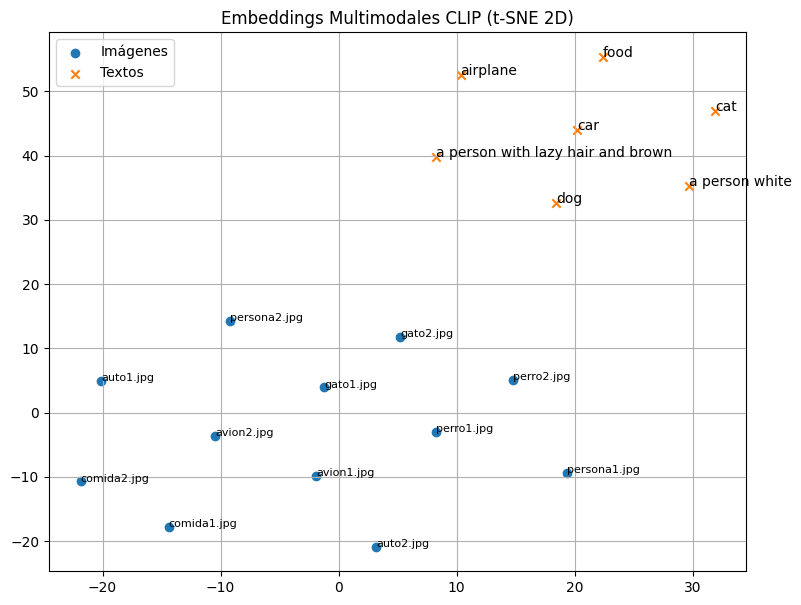

In [ ]:
plt.figure(figsize=(9,7))

plt.scatter(img_2d_tsne[:,0], img_2d_tsne[:,1], marker='o', label='Imágenes')
for i, name in enumerate(image_paths):
    plt.text(img_2d_tsne[i,0], img_2d_tsne[i,1], name, fontsize=8)

plt.scatter(txt_2d_tsne[:,0], txt_2d_tsne[:,1], marker='x', label='Textos')
for i, txt in enumerate(texts):
    plt.text(txt_2d_tsne[i,0], txt_2d_tsne[i,1], txt, fontsize=10)

plt.title("Embeddings Multimodales CLIP (t-SNE 2D)")
plt.legend()
plt.grid(True)
plt.show()


Se visualizan los embeddings de imágenes y textos reducidos a dos dimensiones mediante PCA.  
El gráfico permite observar cómo CLIP agrupa conceptos visuales y textuales relacionados dentro de un mismo espacio semántico.

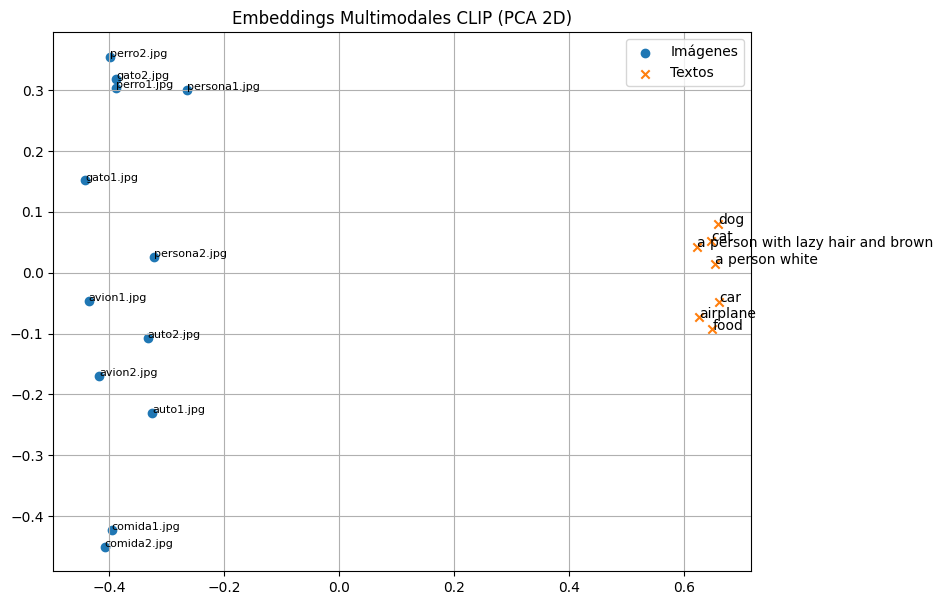

In [ ]:
plt.figure(figsize=(9,7))

plt.scatter(img_2d_pca[:,0], img_2d_pca[:,1], marker='o', label='Imágenes')
for i, name in enumerate(image_paths):
    plt.text(img_2d_pca[i,0], img_2d_pca[i,1], name, fontsize=8)

plt.scatter(txt_2d_pca[:,0], txt_2d_pca[:,1], marker='x', label='Textos')
for i, txt in enumerate(texts):
    plt.text(txt_2d_pca[i,0], txt_2d_pca[i,1], txt, fontsize=10)

plt.title("Embeddings Multimodales CLIP (PCA 2D)")
plt.legend()
plt.grid(True)
plt.show()


Esta función recibe una descripción en texto, genera su embedding con CLIP y calcula la similitud con los embeddings de las imágenes.  
La imagen con mayor similitud semántica es seleccionada y mostrada como resultado.

In [ ]:
def buscar_imagen(texto):
    token = clip.tokenize([texto]).to(device)

    with torch.no_grad():
        emb = model.encode_text(token)
        emb /= emb.norm(dim=-1, keepdim=True)

    scores = cosine_similarity(
        emb.cpu().numpy(),
        image_embeddings.cpu().numpy()
    )[0]

    idx = np.argmax(scores)

    print("Texto:", texto)
    print("Imagen más similar:", image_paths[idx])
    plt.imshow(Image.open(image_paths[idx]))
    plt.axis("off")
    plt.show()


Esta función recibe una imagen, genera su embedding visual y calcula su similitud con los embeddings de texto.  
El texto con mayor similitud semántica es identificado como la descripción más cercana a la imagen.

In [ ]:
def buscar_texto(nombre_imagen):
    img = preprocess(Image.open(nombre_imagen).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        emb = model.encode_image(img)
        emb /= emb.norm(dim=-1, keepdim=True)

    scores = cosine_similarity(
        emb.cpu().numpy(),
        text_embeddings.cpu().numpy()
    )[0]

    text_scores = zip(texts, scores)
    text_scores = sorted(text_scores, key=lambda x: x[1], reverse=True)
    print(text_scores)

    idx = np.argmax(scores)

    print("Imagen:", nombre_imagen)
    print("Texto más cercano:", texts[idx])
    plt.imshow(Image.open(nombre_imagen))
    plt.axis("off")
    plt.show()


Se prueba la función de búsqueda ingresando un texto de consulta.  
El modelo devuelve la imagen cuyo contenido visual es más cercano semánticamente al término ingresado.

Texto: motor
Imagen más similar: auto1.jpg


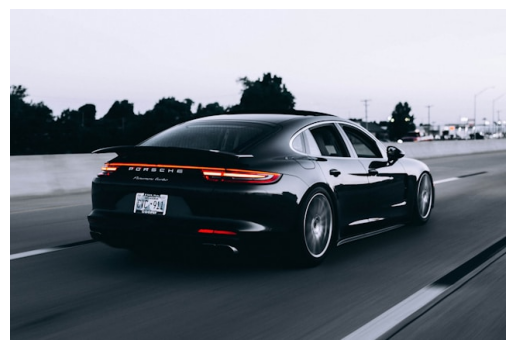

In [ ]:
buscar_imagen("motor")

En esta celda se evalúa la función inversa, donde a partir de una imagen se identifica el texto más cercano semánticamente.  
El resultado permite validar que el modelo CLIP relaciona correctamente el contenido visual con descripciones textuales.

[('food', np.float64(0.2221815106634661)), ('a person white', np.float64(0.1568305915773867)), ('a person with lazy hair and brown', np.float64(0.15585235789922466)), ('car', np.float64(0.15117113262949497)), ('dog', np.float64(0.14338188979982325)), ('airplane', np.float64(0.1394215308953066)), ('cat', np.float64(0.13759741179978127))]
Imagen: comida2.jpg
Texto más cercano: food


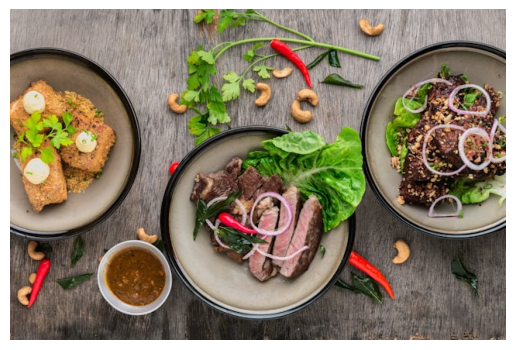

In [20]:
buscar_texto("comida2.jpg")